### Import
In order to predict clients' subscription of the term deposit, we will use typical data science stacks:pandas,numpy,sklearn,matplotlib.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Read in data

In [2]:
# Bank data 
bank_data = pd.read_csv("C:\\Users\\CH.Meng\\Desktop\\bank-additional-full.csv",sep= ";")
print("Data shape:",bank_data.shape)
bank_data.head()

Data shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Exploratory Data Analysis
In this section we will conduct the Exploratory Data Analysis(EDA), which is a open-ended method,to discover what dataset can tell us. Besides, we will also do the data process along the way.

### Examine the Distribution of the Target Column
We define the column y in the dataset as the **Target Column**, for the target of the project is to predict the clients' decision to subscribe bank term deposit.When examining the ditribution of the **Target Column**, we would like to find out the balance of the **Target Column**.

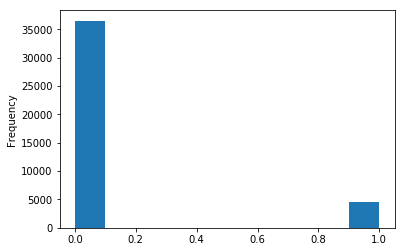

In [3]:
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1}).astype(int)    
pd.Series(bank_data['y']).plot.hist();

From the chart above, we see this is an imbalanced class problem. The amount of the unsubscription of term deposit is much larger than the subscription, which brings the efficiency problem to the bank's marketing campaign. To optimize the bank's marketing strategy, we will give our **Business Suggestion** in the last part of our notebook. 

### Examine Missing Values
In this section, we will look at the number and precentage of the missing value in each column.

In [4]:
#Replace the original indicators of the missing values:unknown,999
bank_data.replace({'job':'unknown','marital':'unknown','education':'unknown','default':'unknown','housing':'unknown',
                     'loan':'unknown','pdays':999},np.nan,inplace = True);


In [5]:
#Counting the missing values
def missing_values_count(data):
        # Calculate total missing values and percentage of missing values in each column
        mis_val = data.isnull().sum()
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : ' % of Total Values'})
        
        # Sort the table by percentage of missing in descending sequence
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        ' % of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(data.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values_count(bank_data)

Your selected dataframe has 21 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
pdays,39673,96.3
default,8597,20.9
education,1731,4.2
housing,990,2.4
loan,990,2.4
job,330,0.8
marital,80,0.2


In [7]:
#For those columns with less miss values:job marital,we delete the corresponding row
data = bank_data[~((bank_data['job'].isnull()) | (bank_data['marital'].isnull()))]
print("data shape:{}".format(data.shape))
data = data.reset_index(drop = True)

data shape:(40787, 21)


### Examine Categorical Variable
As the attribute information indicates, there are several categorical varibles in the dataset. In this part,we will make an overview of the categorical variables and process them in convenience for our model.

In [8]:
#Detect the Categorical Variables
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

job            11
marital         3
education       7
default         2
housing         2
loan            2
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

From the information above, we can see that there are no missing values in those columns:**job**, **marital**, **contact**, **month**, **day_of_week**, **poutcome**, **y**. And we will encode the catagorical varibles in the following steps.

In [9]:
#Count the number of attribute in the column 'education'
data.education.value_counts()

university.degree      12096
high.school             9464
basic.9y                6006
professional.course     5225
basic.4y                4118
basic.6y                2264
illiterate                18
Name: education, dtype: int64

Since the education level is an Ordered Categorical Varible,we will encode it with integer.

In [10]:
def encode_education(data):
    values = ["illiterate", "basic.4y", "basic.6y", "basic.9y", 
    "high.school",  "professional.course", "university.degree"]
    levels = range(1,len(values)+1)
    dict_levels = dict(zip(values, levels))
    for v in values:
        data.loc[data['education'] == v, 'education'] = dict_levels[v]
    return data

And now we have the encoded column 'education'. 

In [11]:
encode_education(data);

As for the 'month', we will draw the frequncy plot first to make an overview of its status for further processing.

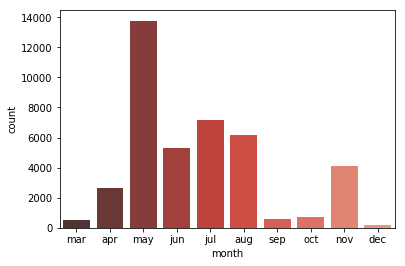

In [12]:
#month
month = bank_data.month
fig,ax = plt.subplots(1,1)
sns.countplot(x="month", data=bank_data, palette="Reds_d", ax=ax,order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


Then we will adopt One-hot encoding to creat new columns for each unique category in the following categorical variables: 'job', 'marital', 'month', 'day_of_week' and 'poutcome'.Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

In [13]:
#Encode the categorical variable with no missing values

cat_variables = ['job','marital','month','day_of_week','poutcome',]
data = pd.get_dummies(data,columns = cat_variables)

As for the **'contact'**, **'default'**, **'housing'**, **'loan'** and **'y'**, we regard them as binary varibles.

In [14]:
def encode_bin(data, bin_features):    
    data.loc[data['contact'] == 'telephone', 'contact'] = 0
    data.loc[data['contact'] == 'cellular', 'contact'] = 1
    for i in bin_features:
        data.loc[data[i] == 'no', i] = 0
        data.loc[data[i] == 'yes', i] = 1
    return data
encode_bin(data,['default','housing','loan']);

As for the **'pdays'**, even though it varies from person to person, yet the '999',which indicates non-previously-contacted clients, takes up 96.3% of the column 'pdays', so we can conlude that **'pdays'** only tells us wheather the client is contacted. As a result,we believe making it an binary varible can help our model perform well.

In [15]:
data.loc[data['pdays'].isnull(),'pdays'] = 0
data.loc[data['pdays']!=0,'pdays'] = 1

### Examine Continuous Variable
In this section, we will process those continuous variables as indicated in the Attribute Information.

First,let's take a look at the frequency distribution of 'Age'.

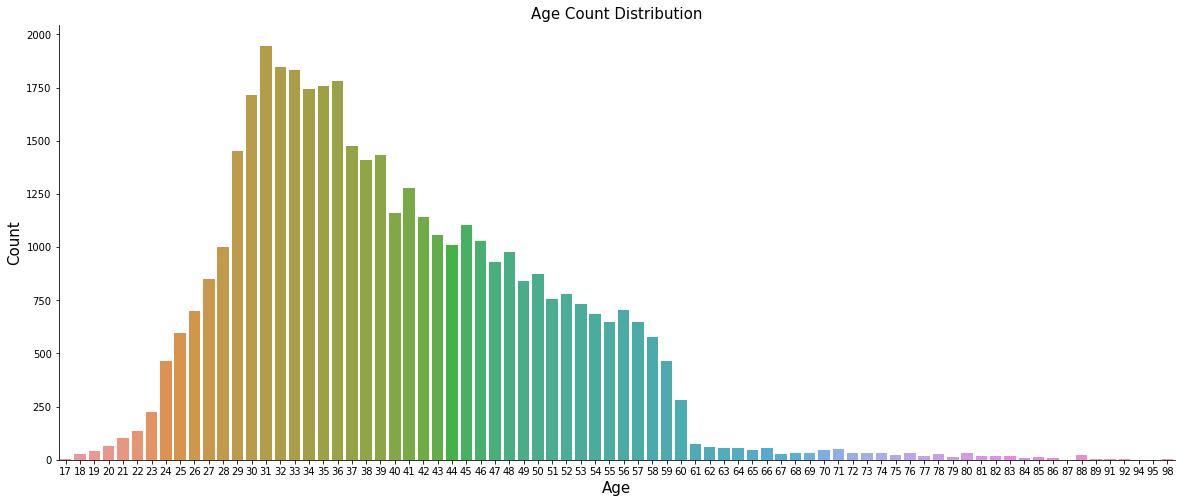

In [16]:
# Age
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'age', data = bank_data)
ax1.set_xlabel('Age', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Age Count Distribution', fontsize=15)
sns.despine()

The graph above indicates that the data has fluctuation, yet it seems not that clear. So we will draw a box plot to find the status of 1st quantile, median and 3rd quantile to have an intuitive visualization.

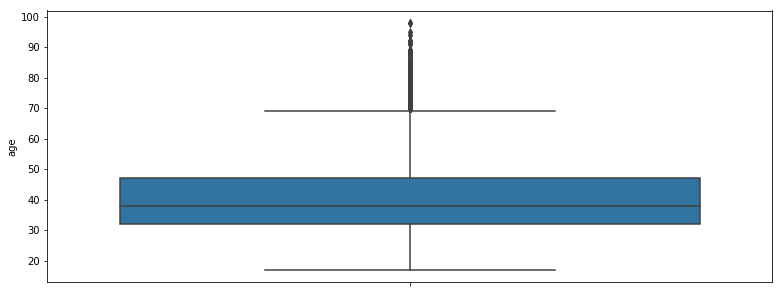

In [17]:
fig, ax2 = plt.subplots(figsize = (13, 5))
sns.boxplot(x = 'age', data = bank_data, orient = 'v')
ax1.set_xlabel('People Age', fontsize=15)
ax1.set_ylabel('Age', fontsize=15)
ax1.set_title('Age Distribution', fontsize=15)
ax1.tick_params(labelsize=15)

From the pictures above,we find the distribution of age is very sparse,and there may be many outliers.Therefore we will discretize it to minimize the negtive effect that the data might bring to our model.

Then we will examine the distribution of 'Duration'.

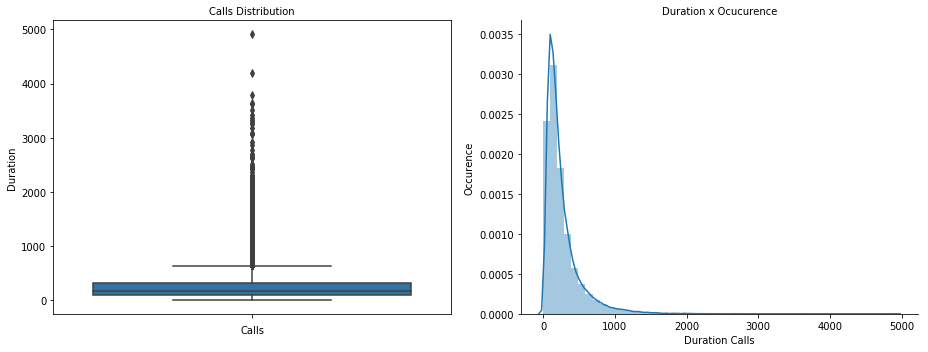

In [18]:
#Duration
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'duration', data = bank_data, orient = 'v', ax = ax1)
ax1.set_xlabel('Calls', fontsize=10)
ax1.set_ylabel('Duration', fontsize=10)
ax1.set_title('Calls Distribution', fontsize=10)
ax1.tick_params(labelsize=10)

sns.distplot(bank_data['duration'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Duration Calls', fontsize=10)
ax2.set_ylabel('Occurence', fontsize=10)
ax2.set_title('Duration x Ocucurence', fontsize=10)
ax2.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

From the graphe above, we could find out that the data of 'Duration' has great fluctuation. So we will nondimensinalize the data using the standardtization method. For our convenience of running the model, we would do the same to 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euibor3m' and 'nr.employed'.

To summarize,as for 'age', we discretize it to minimize the negtive effect of the anomalies. When it comes to 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euibor3m' and 'nr.employed', we standardtize them to do the nondimensionalization.

In [19]:
def trans_numeric(data, numeric_features):
    bining_num = 10
    bining_feature = 'age'
    data[bining_feature] = pd.qcut(data[bining_feature], bining_num)
    data[bining_feature] = pd.factorize(data[bining_feature])[0]+1   
    for i in numeric_features: 
        mms = preprocessing.MinMaxScaler()
        data[i] = mms.fit_transform(np.array(data[i]).reshape(-1,1))
    return data
trans_numeric(data,['duration','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']);

Now that we have finished the encoding, we will fill the missing value with the adoption of **Random Forest**

In [20]:
def fill_null(data):
    fill_attrs = ['education','default','housing','loan']
    for i in fill_attrs:     
        test_data = data.loc[data[i].isnull()]
        testX = test_data.drop(fill_attrs, axis=1)
        train_data = data.loc[~data[i].isnull()]        
        trainY = train_data.loc[:,i]
        trainX = train_data.drop(fill_attrs, axis=1)    
        test_data[i] = train_predict_null(trainX, trainY.astype('int'), testX)
        data = pd.concat([train_data, test_data])    
    return data

def train_predict_null(trainX, trainY, testX):
    forest = RandomForestClassifier(n_estimators=100)
    forest = forest.fit(trainX, trainY)
    test_predictY = forest.predict(testX).astype(int)
    return pd.DataFrame(test_predictY,index=testX.index)

In [21]:
final_data = fill_null(data)

### Correlation
Now that we have dealt with the data,we will continue with the EDA. The Pearson Corrlation Coefficient can help us understand the relationship between the varible and the column y,which we define as the Target Column. Therefore, we will calculate the Pearson Corrlation Coefficient in the step below.

In [22]:
correlations = final_data.corr()['y'].sort_values()

In [23]:
print('Most Positive Correlations:\n', correlations.tail(15))
print('Most Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 marital_single      0.053505
cons.conf.idx       0.054208
month_apr           0.076516
month_dec           0.079238
job_retired         0.092674
job_student         0.094556
month_sep           0.126201
month_oct           0.137481
month_mar           0.144433
contact             0.144654
previous            0.229090
poutcome_success    0.317898
pdays               0.324363
duration            0.405312
y                   1.000000
Name: y, dtype: float64
Most Negative Correlations:
 nr.employed            -0.354615
euribor3m              -0.307590
emp.var.rate           -0.298024
poutcome_nonexistent   -0.192562
cons.price.idx         -0.135854
month_may              -0.107210
job_blue-collar        -0.075170
campaign               -0.066419
age                    -0.043458
marital_married        -0.042109
month_jul              -0.032636
job_services           -0.032303
day_of_week_mon        -0.020574
job_entrepreneur       -0.017011
month_nov            

From the correlation analysis,we discover that in those positive and negative correlations, the rank of month_sep,month_oct, month_mar, month_nov and month_july is very high. However, the sigular month itself doesn't have much difference among other month. Therefore,we believe we can construct a new feature-'Quarter' in the Feature Engineering.

## Feature Engineering

### Feature Establishment

We will do the Feature Establishment accroding to the method above.

In [24]:
# Feature establish
final_data['spring'] = final_data['month_mar']
final_data['summer'] = final_data['month_apr']+final_data['month_may']+final_data['month_jun']
final_data['autumn'] = final_data['month_jul']+final_data['month_aug']+final_data['month_sep']
final_data['winter'] = final_data['month_oct']+final_data['month_nov']+final_data['month_dec']


Now we have the final version of our dataset is listed as followed.

In [25]:
final_data.head(10)

,age,education,default,housing,loan,contact,duration,campaign,pdays,previous,...,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,spring,summer,autumn,winter
0,1,2,0,0,0,0,0.053070,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
2,2,5,0,1,0,0,0.045954,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
3,3,3,0,0,0,0,0.030704,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
4,1,5,0,0,1,0,0.062424,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
6,1,6,0,0,0,0,0.028264,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
8,5,6,0,1,0,0,0.077267,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
9,5,5,0,1,0,0,0.010167,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
11,5,5,0,1,0,0,0.045140,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
12,6,5,0,0,1,0,0.027857,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
13,1,2,0,1,0,0,0.059577,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0


In [26]:
final_data.spring.value_counts()

0    40246
1      541
Name: spring, dtype: int64

### Feature Selection
In this section, we adopt the Rondom Forest to conduct the feature selection.

Before we run the Random Forest, we will sepreate the test set and training set from the original dataset.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_data.drop('y',axis=1), final_data['y'], test_size = 0.1942313295, random_state = 101)

In [28]:
from sklearn.ensemble import RandomForestClassifier
feat_lables = X_train.columns
forest = RandomForestClassifier(n_estimators=1000, random_state=0,n_jobs=1,criterion = 'entropy')
forest.fit(X_train,y_train)
importance = forest.feature_importances_
imp_result = np.argsort(importance)[::-1]
imp_result[0:5]

array([ 6, 13,  0, 14,  7], dtype=int64)

In [29]:
for i in range(X_train.shape[1]):
    print("%2d. %-*s %f"%(i+1, 30, feat_lables[i], importance[imp_result[i]]) )

 1. age                            0.328049
 2. education                      0.099511
 3. default                        0.055042
 4. housing                        0.054888
 5. loan                           0.043297
 6. contact                        0.038428
 7. duration                       0.033511
 8. campaign                       0.026450
 9. pdays                          0.021729
10. previous                       0.019609
11. emp.var.rate                   0.019265
12. cons.price.idx                 0.016062
13. cons.conf.idx                  0.012688
14. euribor3m                      0.012558
15. nr.employed                    0.011979
16. job_admin.                     0.011774
17. job_blue-collar                0.011569
18. job_entrepreneur               0.011282
19. job_housemaid                  0.010959
20. job_management                 0.010854
21. job_retired                    0.010593
22. job_self-employed              0.010390
23. job_services                

According to the result above, we would like to select the top 15 features and drop the rest of them.

In [30]:
final_data.drop(['job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_student',
                 'job_technician','job_unemployed','job_self-employed','job_services','marital_divorced','marital_married',
                 'marital_single','day_of_week_fri','day_of_week_mon','day_of_week_thu','day_of_week_tue','day_of_week_wed',
                 'poutcome_failure','poutcome_nonexistent','poutcome_success','spring','summer','autumn','winter'],axis = 1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(final_data.drop('y',axis=1), final_data['y'], test_size = 0.1942313295, random_state = 101)

### Performance Metrics
In this section, we will use **F1 Scoring** and **P/R Metric** to evaluate the performance of our Random Forest.F1 Scoring is a indicator to evaluate the stability binary model. As for the P/R Metric, it discover the balance between the Precision and Recall, which is a group of contradictory indicator. Since we adopt the Random Forest, those metrics will be good performance evaluation metrics.

First, we will do the F1 Scoring as followed. 

In [31]:
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as con

clf = RandomForestClassifier(class_weight='balanced',random_state=2018)
result = clf.fit(X_train,y_train).predict(X_test)

print('\n'+'confusion matrix：')
print(con(y_test,result))

print('\n'+'F1 Score：')
print(f1(y_test,result))
print('\n'+'Accuracy:')
print("score:{:.2f}".format(clf.score(X_test,y_test)))


confusion matrix：
[[6873  193]
 [ 501  356]]

F1 Score：
0.5064011379800853

Accuracy:
score:0.91


From the result above, we can see that the **F1 Score** is 0.51 and the **Accuracy** is 91%, which indicates that our model is robust.

Then we will do the P/R Metric.

In [32]:
def plot_pr(auc_score, precision, recall, label=None):  
    pylab.figure(num=None, figsize=(6, 5))  
    pylab.xlim([0.0, 1.0])  
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')  
    pylab.ylabel('Precision')  
    pylab.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))  
    pylab.fill_between(recall, precision, alpha=0.2)  
    pylab.grid(True, linestyle='-', color='0.75')  
    pylab.plot(recall, precision, lw=1)      
    pylab.show()
    


def plot_roc(auc_score, fpr, tpr, label=None):  
    pylab.figure(num=None, figsize=(6, 5))  
    pylab.xlim([0.0, 1.0])  
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('False positive rate')  
    pylab.ylabel('True positive rate')  
    pylab.title('ROC (AUC=%0.2f) / %s' % (auc_score, label))  
    pylab.fill_between(fpr, tpr, alpha=0.2)  
    pylab.grid(True, linestyle='-', color='0.75')  
    pylab.plot(fpr, tpr, lw=1)      
    pylab.show()


Accuracy: 0.9124069165720056
             precision    recall  f1-score   support

         no       0.93      0.97      0.95      7066
        yes       0.65      0.42      0.51       857

avg / total       0.90      0.91      0.90      7923



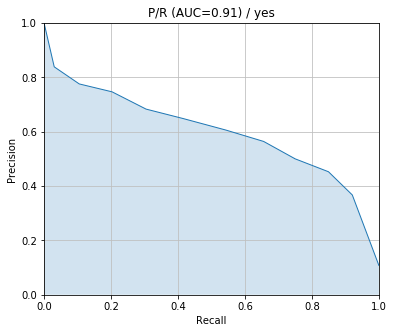

In [33]:
from sklearn.metrics import classification_report
from sklearn import metrics
from matplotlib import pylab

prodict_prob_y = clf.predict_proba(X_test)[:,1]
report = classification_report(y_test, prodict_prob_y > 0.5,target_names = ['no','yes'])
prodict_y = (prodict_prob_y > 0.5).astype(int)
accuracy = np.mean(y_test.values == prodict_y)
print("Accuracy: {}".format(accuracy))    
print(report)
fpr, tpr, thresholds = metrics.roc_curve(y_test, prodict_prob_y)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, prodict_prob_y)  
test_auc = metrics.auc(fpr, tpr)
plot_pr(test_auc, precision, recall, "yes")
    

The P/R Metric indicates the **Accuracy** is 91%. What is more, the P/R graphe shows that the AUC is 0.91.

From the evaluation above, we can draw a conclusion that our model is robust. And the following suggestion generating from the model shall be solid.

## Business Suggestion

### Client Selection

It's a social phenomenon that the elderly people usually work for a long period of time, accumulating plenty wealth. This kind has a lower demand for consumption but a higher demand for risk aversion, comparing to the youth. The bank should identify them as potential depositor.

Education reflects people's knowledge level and work ability, therefore, it is more likely for people highly educated to deposit surplus income.
It is recommended that banks pay more attention to this kind of people 

The record of defaults indicate clients' high credit risk. They have no willingness to deposit. It is recommended that banks exclude customers who are untrustworthy.

Customers with debts and repayments are under a lot of pressure, cash flow is tight, and there is almost no willingness to deposit. It is recommended that banks exclude customers who are untrustworthy and will not consider them.

### Marketing Strategy

We find that the performance of banks is closely related to the situation of potential customers when contacting. We suggest that banks should increase the frequency and length of communication with customers to excavate potential customers, and enhance customer stickiness, so that customers have a strong willingness to deposit.

### Risk Managment

Customer's deposit intention is inevitably affected by macroeconomic factors. We suggest that banks take into account the actual economic environment and the expectations of customer groups on the economic environment, and combine static and dynamic indicators to predict the impact of economic environment on customer's deposit intention, so as to make a reasonable response. At present, deposit and loan business is still the core source of bank profits. Effective judgment of economic environment can reasonably control the risks faced by banks.
